In [3]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator, load_img

import tensorflow as tf
import keras

import cv2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D,GlobalAveragePooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint,ReduceLROnPlateau

from tensorflow.keras.optimizers import Adam

In [4]:
pip install opencv-python

Note: you may need to restart the kernel to use updated packages.


In [5]:
main_dir = 'C:/Users/LapStorePlus/Desktop/trials_tools/chest_xray/'
train_data_dir ='C:/Users/LapStorePlus/Desktop/trials_tools/chest_xray/train/'
validation_data_dir = main_dir + "val/"
test_data_dir = main_dir + "test/"
print("Working Directory Contents:", os.listdir(main_dir))

Working Directory Contents: ['.DS_Store', 'test', 'train', 'val']


In [6]:
train_n = train_data_dir+'NORMAL/'
train_p = train_data_dir+'PNEUMONIA/'

print("length of cases in training set:",len(os.listdir(train_p)) + len(os.listdir(train_n)))
print("length of pneumonia cases in training set:",len(os.listdir(train_p)))
print("length of normal cases in training set:",len(os.listdir(train_n)))

length of cases in training set: 5218
length of pneumonia cases in training set: 3876
length of normal cases in training set: 1342


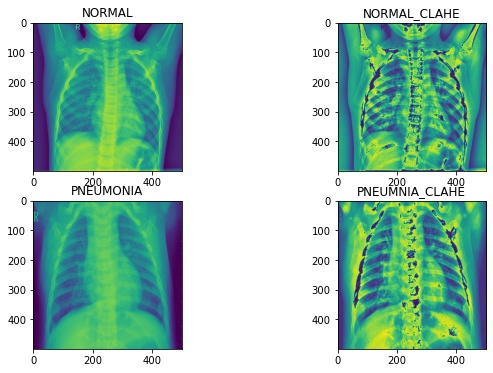

In [7]:
clahe = cv2.createCLAHE(clipLimit = 5)


img_name = 'IM-0115-0001.jpeg'
img_normal = cv2.imread('C:/Users/LapStorePlus/Desktop/trials_tools/chest_xray/train/NORMAL/' + img_name)
img_normal = cv2.resize(img_normal, (500,500))
img_normal = cv2.cvtColor(img_normal, cv2.COLOR_BGR2GRAY)
img_normal_clahe = clahe.apply(img_normal) + 30



img_name_1 = 'person1000_virus_1681.jpeg'
img_pneumonia = cv2.imread('C:/Users/LapStorePlus/Desktop/trials_tools/chest_xray/train/PNEUMONIA/' + img_name_1)
img_pneumonia = cv2.resize(img_pneumonia, (500,500))
img_pneumonia = cv2.cvtColor(img_pneumonia, cv2.COLOR_BGR2GRAY)
img_pneumonia_clahe = clahe.apply(img_pneumonia) + 30


#-----------------------------------------------------------------------------------------#


fig, axs = plt.subplots(2,2,figsize=(10,6))
axs[0,0].imshow(img_normal)
axs[0,0].set_title("NORMAL")
axs[0,1].imshow(img_normal_clahe)
axs[0,1].set_title("NORMAL_CLAHE")
axs[1,0].imshow(img_pneumonia)
axs[1,0].set_title("PNEUMONIA")
axs[1,1].imshow(img_pneumonia_clahe)
axs[1,1].set_title("PNEUMNIA_CLAHE");

In [8]:
img_width , img_height = [224,224]
batch_size = 16

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=[0.2,1.0],
    horizontal_flip=True)


test_datagen = ImageDataGenerator(rescale=1. / 255)
val_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',
    shuffle = True)

validation_generator = val_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary')

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary')

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


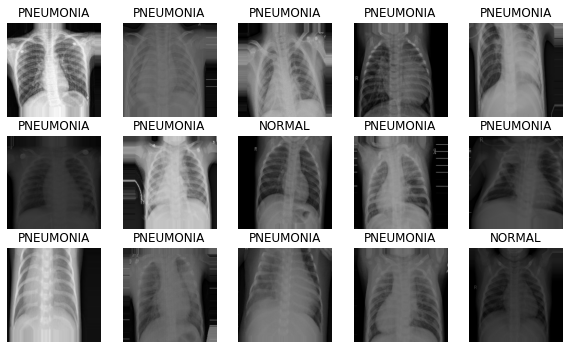

In [9]:
image_batch, label_batch = next(iter(train_generator))

def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10, 10))
    for n in range(15):
        ax = plt.subplot(5, 5, n + 1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")

show_batch(image_batch, label_batch)

In [10]:
nb_train_samples = 5216 # number of training samples
nb_validation_samples = 16 # number of validation samples
nb_test_samples = 624 # number of training samples
epochs = 10  # number of epochs we gonna run
batch_size  = 16 # batch size ( at every iteration it will take 16 batches for training)

In [13]:
from tensorflow.keras.applications.densenet import DenseNet169
from tensorflow.keras.applications.densenet import preprocess_input as densenet_preprocess



densenet_model = Sequential()

densenet_model.add(Conv2D(16, kernel_size=(3, 3),activation='relu',input_shape = (224, 224, 3)))
densenet_model.add(BatchNormalization())

densenet_model.add(Conv2D(32, (3, 3), activation='relu'))
densenet_model.add(Dropout(0.5))
densenet_model.add(BatchNormalization())
densenet_model.add(Dense(64, activation='relu'))
densenet_model.add(Dropout(0.5))

densenet_model.add(Conv2D(64, (3, 3), activation='relu')) 
densenet_model.add(MaxPooling2D(pool_size=(2, 2)))
densenet_model.add(Dense(128, activation='relu')) 
densenet_model.add(MaxPooling2D(pool_size=(2, 2)))

densenet_model.add(Conv2D(128, (3, 3), activation='relu')) 
densenet_model.add(BatchNormalization())
densenet_model.add(MaxPooling2D(pool_size=(2, 2)))

densenet_model.add(Flatten())

densenet_model.add(Dense(256, activation='relu'))
densenet_model.add(BatchNormalization())
densenet_model.add(Dense(1, activation='sigmoid'))

densenet_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 16)      448       
_________________________________________________________________
batch_normalization (BatchNo (None, 222, 222, 16)      64        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 220, 220, 32)      4640      
_________________________________________________________________
dropout (Dropout)            (None, 220, 220, 32)      0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 220, 220, 32)      128       
_________________________________________________________________
dense (Dense)                (None, 220, 220, 64)      2112      
_________________________________________________________________
dropout_1 (Dropout)          (None, 220, 220, 64)      0

In [14]:
# defined optimizer
optm = Adam(lr=0.0001)
densenet_model.compile(loss='binary_crossentropy', optimizer=optm, 
                  metrics=['accuracy'])

rlr = ReduceLROnPlateau( monitor="val_accuracy",
                            factor=0.01,
                            patience=3,
                            verbose=0,
                            mode="max",
                            min_delta=0.01)

model_save = ModelCheckpoint('./densenet169.h5',
                             save_best_only = True,
                             save_weights_only = False,
                             monitor = 'val_loss', 
                             mode = 'min', verbose = 1)


In [15]:
dense_history = densenet_model.fit(train_generator,
                              steps_per_epoch = nb_train_samples // batch_size,
                              epochs = 10,
                              validation_data = validation_generator,
                              callbacks=[model_save,rlr]
                           )

Epoch 1/10
326/326 [==============================] - 1822s 6s/step - loss: 0.4748 - accuracy: 0.7887 - val_loss: 3.2526 - val_accuracy: 0.6250

Epoch 00001: val_loss improved from inf to 3.25259, saving model to .\densenet169.h5
Epoch 2/10
326/326 [==============================] - 1522s 5s/step - loss: 0.3427 - accuracy: 0.8648 - val_loss: 0.8235 - val_accuracy: 0.6506

Epoch 00002: val_loss improved from 3.25259 to 0.82345, saving model to .\densenet169.h5
Epoch 3/10
326/326 [==============================] - 1502s 5s/step - loss: 0.2903 - accuracy: 0.8909 - val_loss: 1.1702 - val_accuracy: 0.6603

Epoch 00003: val_loss did not improve from 0.82345
Epoch 4/10
326/326 [==============================] - 1498s 5s/step - loss: 0.2640 - accuracy: 0.9001 - val_loss: 0.8391 - val_accuracy: 0.6843

Epoch 00004: val_loss did not improve from 0.82345
Epoch 5/10
326/326 [==============================] - 1792s 5s/step - loss: 0.2449 - accuracy: 0.9049 - val_loss: 0.6939 - val_accuracy: 0.7276


In [16]:
def plot(history):

    training_accuracy = history.history['accuracy']
    validation_accuracy = history.history['val_accuracy']

    training_loss = history.history['loss']
    validation_loss = history.history['val_loss']

    epochs_range=range(len(training_accuracy))

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, training_accuracy, label='Training Accuracy')
    plt.plot(epochs_range, validation_accuracy, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, training_loss, label='Training Loss')
    plt.plot(epochs_range, validation_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

In [17]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

from PIL import Image
def predict(image_path, model):
    im = cv2.imread(image_path)
    test_image = np.asarray(im)
    processed_test_image = process_image(test_image)
    processed_test_image = np.expand_dims(processed_test_image, axis = 0)
    
    ps = model.predict(processed_test_image)
    return ps
    
def process_image(image):
    image = image/255
    image = cv2.resize(image, (224,224))
    return image


def testing(model, test_df):
    """ the passed data must be the img_path columns and label column"""
    base_pred =[]
    for image in test_df.img_path:
        base_pred.append(predict(image , model)[0][0])
    
    final_base_pred  = np.where(np.array(base_pred)>0.5,1,0)
    actual_label = test_df['label']
    # print(final_base_pred)

    print(classification_report(actual_label, final_base_pred))
    matrix=confusion_matrix(actual_label, final_base_pred)
    sns.heatmap(matrix,square=True, annot=True, fmt='d', cbar=False,
            xticklabels=['0', '1'],
            yticklabels=['0', '1'])
    plt.xlabel('Predicted label')
    plt.ylabel('True label')

In [18]:
test_data = []
test_normal_path = test_data_dir + '/NORMAL'
test_pneumonia_path = test_data_dir + '/PNEUMONIA'
for filename in os.listdir(test_normal_path):
    test_data.append((os.path.join(test_normal_path,filename),0))
for filename in os.listdir(test_pneumonia_path):
    test_data.append((os.path.join(test_pneumonia_path,filename),1))    
    
    
    
    
test_df = pd.DataFrame(test_data, columns = ['img_path','label'], index = None)
# this test_df must contain the img_path and label column in order to run the function  

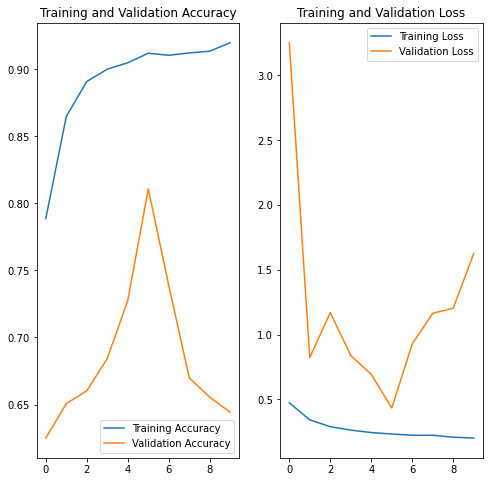

In [19]:
plot(dense_history)

In [20]:
densenet_model = keras.models.load_model('./densenet169.h5')

              precision    recall  f1-score   support

           0       0.85      0.59      0.70       234
           1       0.79      0.94      0.86       390

    accuracy                           0.81       624
   macro avg       0.82      0.76      0.78       624
weighted avg       0.81      0.81      0.80       624



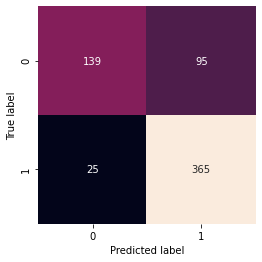

In [22]:
testing(densenet_model, test_df)

In [25]:
def predict_image(validation_df, model):
    plt.figure(figsize=(6,6))
    for index , data in validation_df[:10].iterrows():
        img_name = data['img_path']
        label = data['label']
    
        label_predicted = np.where((predict(img_name , model)[0][0])>0.5,'pneumonia','normal')
        plt.imshow(load_img(img_name, target_size = (120,120)))
        if label == 1:
            plt.xlabel(f"True:Pneumonia, Predicted:{label_predicted}", fontsize = 15)
        if label == 0:
            plt.xlabel(f"True:Normal, Predicted:{label_predicted}", fontsize = 15)
            
        plt.tight_layout()
        plt.show()

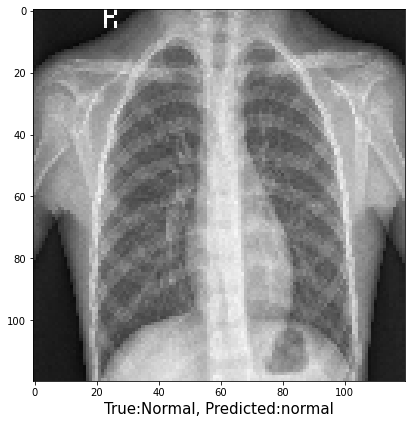

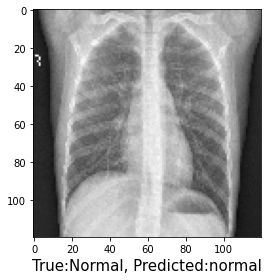

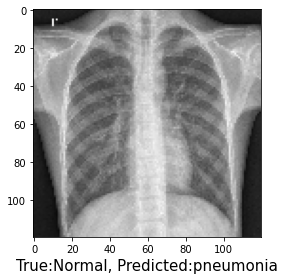

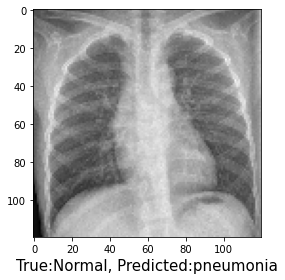

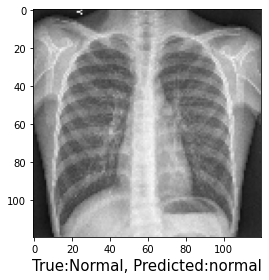

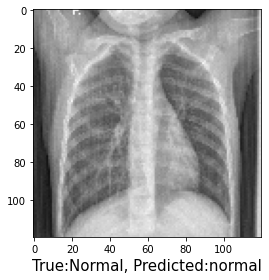

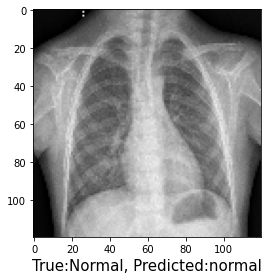

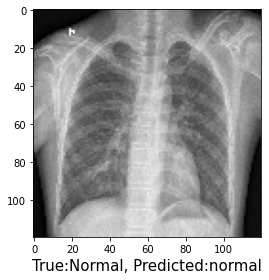

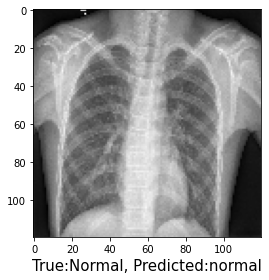

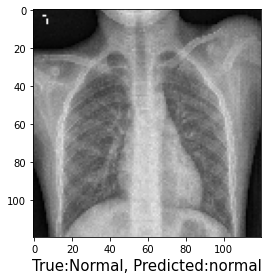

In [29]:
predict_image(test_df, densenet_model)